## 05- Usos del Modelo

Existen diversas aplicaciones de negocio con el resultado u output de la herramienta analítica de churn. Debido a que esta arroja una probabilidad (0 a 1) de que un cliente no renueve su póliza. Este valor puede asumirse como una medición del grado de satisfacción del cliente con el servicio u producto obtenido. En ese orden de ideas, diversas iniciativas pueden proponerse usando como fuente la probabilidad de churn de los clientes, algunas pueden ser:

- Caracterización de clientes de mayor riesgo de churn
- Estimación del customer value en términos de su probabilidad de churn
- Campañas de fidelización de los clientes con mayor riesgo de churn
- Estrategias de renovación o venta cruzada para los clientes de menor riesgo de churn

A continuación se realiza una pequeña caracterización de los clientes con mayor probabilidad de churn que tomaron pólizas en Febrero de 2022.

In [1]:
from model_parameters import *
import pickle
import pandas as pd
import numpy as np
from sklearn import set_config

set_config(display='diagram')

#cargue del modelo
with open("models/lightgbm.pickle", 'rb') as f:
    lightgbm = pickle.load(f)

with open("models/logistic.pickle", 'rb') as f:
    logistic = pickle.load(f)


### Cargue de data feb 2022 generada en notebook 01

In [9]:
data=pd.read_csv("polizas_feb22.csv",sep=";",dtype={'Asegurado__c':str,'NumeroPoliza__c':str,'CodigoTipoAsegurado__c':str,'churn':int,'ClaseVehiculo__c':str,'TipoVehiculo__c':str,'PuntoVenta__c':str,'MarcaVehiculo__c':str},na_values="nan")

In [10]:
def pred_stack(data,proba=True,thresh=0.5):
    proba_lgb=lightgbm.predict_proba(data)[:,1]
    predict_log=logistic.predict_proba(data)[:,1]
    if proba:
        return np.stack((proba_lgb,predict_log),axis=1).mean(axis=1)
    else:
        return (np.stack((proba_lgb,predict_log),axis=1).mean(axis=1)>thresh).astype(int)

In [11]:
##calcular probabilidad de churn
proba_churn=pred_stack(data)
data['proba_churn']=proba_churn


### Regla de decisión
Al tener la probabilidad de churn, es necesario establecer el valor a partir del cual un cliente es considerado con alto riesgo de churn. Una alternativa es usar los quantiles de la distribución.

Percentil 25: 0.564 y 75: 0.642 


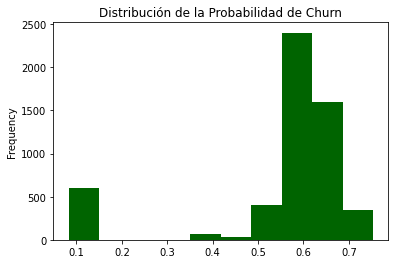

In [12]:
data.proba_churn.plot(kind="hist",title="Distribución de la Probabilidad de Churn", color="darkgreen");
print("Percentil 25: {:.3f} y 75: {:.3f} ".format(*np.quantile(proba_churn,[0.25,0.75])))


Podría decirse que, basado en la distribución de probabilidades de churn de febrero de 2022, el 25% de las probabilidades más altas empiezan a partir de `0.642`. Por tanto asumimos este valor como el punto de corte para clasificar un cliente con alta probabilidad de churn.

In [13]:
clientes_riesgo=data.query("proba_churn>0.642")
print("Total Clientes con alto riesgo de churn: {}".format(clientes_riesgo.shape[0]))

Total Clientes con alto riesgo de churn: 1357


### Analicemos estos clientes

<AxesSubplot:ylabel='Frequency'>

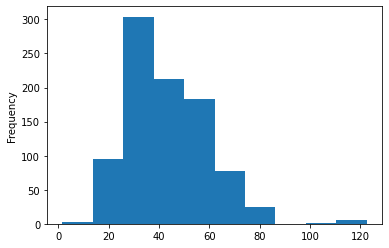

In [15]:
clientes_riesgo.edad.plot(kind="hist")

In [16]:
print("===Caracterización Clientes con Mayor Riesgo de Churn===\n\n \t *Características Cualitativas*")

for col in ['ciudad_name','tipo_prod_desc','EstadoCivil__pc','Genero__pc']:
    print(f"\n \tVariable: {col} \t\n")
    print(clientes_riesgo[col].value_counts(sort=True))

print("\n\t *Características Numéricas*")
for col in ['total_siniestros','edad','AnnualRevenue']:
    value=clientes_riesgo[col].median() if col !="AnnualRevenue" else clientes_riesgo[col].median()/(12*1000000)
    print(f"\n Variable: {col} Valor Mediano: {value:.2f} \t\n")

===Caracterización Clientes con Mayor Riesgo de Churn===

 	 *Características Cualitativas*

 	Variable: ciudad_name 	

otras            805
BOGOTÁ D.C.       49
MEDELLIN          39
CÚCUTA            18
NEIVA             18
ARMENIA           16
YOPAL             11
PASTO              9
BARRANQUILLA       8
POPAYÁN            7
FLORENCIA          7
PEREIRA            7
CALI               7
BUCARAMANGA        6
TULUÁ              4
VILLAVICENCIO      4
CARTAGENA          3
AGUA DE DIOS       3
DOS QUEBRADAS      3
MANIZALES          2
IBAGUÉ             1
Name: ciudad_name, dtype: int64

 	Variable: tipo_prod_desc 	

automoviles                     835
profesionales medicos           405
directores y administradores    112
servidores publicos               5
Name: tipo_prod_desc, dtype: int64

 	Variable: EstadoCivil__pc 	

SOLTERO       583
CASADO        246
N A            94
OTRO           89
UNIDO          11
VIUDO           2
DIVORCIADO      1
SEPARADO        1
Name: EstadoCivil__pc

## Conclusiones

Una posible caracterización de los clientes con mayor riesgo de churn, son los `hombres solteros que contratan pólizas tipo automoviles`, que no viven en ciudades principales cercanos a los `40 años` con ingresos medios de `3 SMMLV` y que han tenido al menos `un siniestro previamente`.

In [17]:
##exportar data de clientes

clientes_riesgo.to_csv("clientes_riesgofeb22.csv",sep=";",index=False)